# 线性分类器 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1
    if add_outliers:
        x2 = np.random.normal(size=10).reshape(-1, 2) + np.array([6., 3.])
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), np.zeros(25)+2]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)


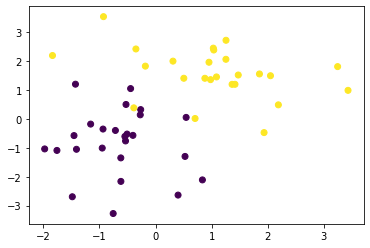

In [3]:
x_train, y_train = create_toy_data()
x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

In [4]:
import itertools
import functools

class PolynomialFeature(object):
    """Polynomial features

    transforms input array with polynomial features

    Example 1
    =========
    x = [a, b]

    y = PolynomialFeature(degree=5).transform(x)
    y = [[1, a, a^2, a^3, a^4, a^5],
         [1, b, b^2, b^3, b^4, b^5]]

    Example 1
    =========
    x = [[a, b],
         [c, d]]

    y = PolynomialFeature(degree=2).transform(x)
    y = [[1, a, b, a^2, a*b, b^2],
         [1, c, d, c^2, c*d, d^2]]
    """
    def __init__(self, degree=2):
        """Construct polynomial features
        
        Params
        ======
        degree: int
          degree of polynomial
        """
        if not isinstance(degree, int):
            raise ValueError("degree should be int type")
        self.degree = degree

    def transform(self, x):
        """Transforms input array with polynomial features

        Params
        ======
        x: ndarray with shape (N, D)
           input array

        Returns
        =======
        output: ndarray with shape (N, K+1)
           polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree+1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.array(features).transpose()


In [5]:
class LabelTransformer(object):
    """label encoder decoder
    
    Attr
    ====
    n_classes: int
        number of classes
    """
    def __init__(self, n_classes=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices):
        """encode class index into one-of-k code
        
        Params
        ======
        class_indices: ndarray with shape (N,)
            non-negative class index
            elements must be integer in [0, n_classes)
        
        Returns
        =======
        output: ndarrray with shape (N, K)
            one-of-k encoding of input
        """
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot):
        """ decode one-of-k code into class index
        
        Params
        ======
        onehot: ndarray with shape (N, K)
            one-of-k code
        
        Returns
        =======
        output: ndarray with shape (N,)
            class index
        """
        return np.argmax(onehot, axis=1)


In [6]:
class LeastSquaresClassifier(object):
    """Least Squares Classifier Model

    Params
    ======
    X: (N, D)
    W: (D, K)
    y = argmax_k X @ W
    """
    def fit(self, X, t):
        """Least squares fitting for classification

        Params
        ======
        X: ndarray with shape (N, D)
           training independent variable
        t: ndarray with shape (N,) or (N, K)
           training dependent variable
           in class index (N,) or one-hot coding (N,K)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.W = np.linalg.pinv(X) @ t

    def classify(self, X):
        """classify input data
        
        Params
        ======
        X: ndarray with shape (N, D)
           independent variable to be classified

        Returns
        =======
        output: ndarray with shape (N)
           class index for each input
        """
        return np.argmax(X @ self.W, axis=-1)


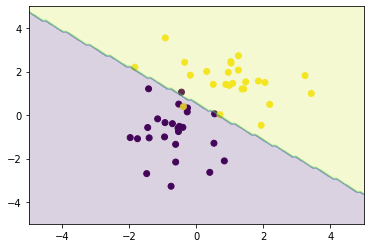

In [7]:
x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(X_train, y_train)
y = model.classify(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1, x2, y.reshape(100, 100), alpha=0.2)#, levels=np.linspace(0, 1, 3))
plt.show()


In [8]:
class FishersLinearDiscriminant(object):
    """ Fisher's Linear Discriminant Model
    """
    def __init__(self, w=None, threshold=None):
        self.w = w
        self.threshold = threshold

    def fit(self, X, t):
        """ estimate parameter given training dataset
        
        Params
        ======
        X: ndarray with shape (N, D)
           training dataset independent variable
        t: ndarray with shape (N,)
           training dataset dependent variable
           binary 0 or 1
        """
        X0 = X[t == 0]
        X1 = X[t == 1]
        m0 = np.mean(X0, axis=0)
        m1 = np.mean(X1, axis=0)
        cov_inclass = np.cov(X0, rowvar=False) + np.cov(X1, rowvar=False)
        self.w = np.linalg.solve(cov_inclass, m1 - m0)
        self.w /= np.linalg.norm(self.w).clip(min=1e-10)

        m = np.mean(X, axis=0)
        self.threshold = self.w @ m

        
    def transform(self, X):
        """project data
        
        Params
        ======
        X: ndarray with shape (N, D)
           
        Returns
        =======
        y: ndarray with shape (N,)
           projected data
        """
        return X @ self.w

    def classify(self, X):
        """classify input data
        
        Params
        ======
        X: ndarray with shape (N, D)
           independent variable to be classified

        Returns
        =======
        output: ndarray with shape (N, D)
           binary class for each input
        """
        return (X @ self.w > self.threshold).astype(np.int)


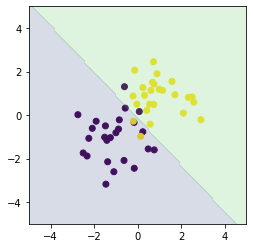

In [9]:
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

model = FishersLinearDiscriminant()
model.fit(x_train, y_train)
y = model.classify(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()